In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from scipy.optimize import curve_fit
import aliensims as dy
from transit import occultnonlin, occultquad

In [2]:
hdu = fits.open('008110757_dvt.fits')
print("number of TCEs:", len(hdu)-2)

number of TCEs: 1


In [3]:
print(hdu[0].header)

SIMPLE  =                    T / conforms to FITS standards                     BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T / file contains extensions                       NEXTEND =                    3 / number of standard extensions                  EXTNAME = 'PRIMARY '           / name of extension                              EXTVER  =                    1 / extension version number (not format version)  ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file DATE    = '2016-03-01'         / file creation date.                            CREATOR = '1165216 DvTimeSeriesExporter2PipelineModule' / pipeline job and progrPROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.43 r61051' / SW version   FILEVER = '2.0     '           / file format version                            TIMVERSN= 'OGIP/93-003'        / OGIP me

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


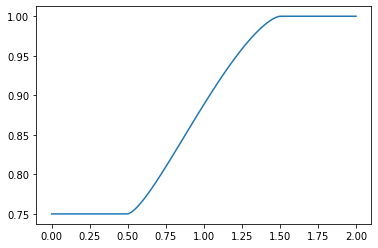

In [4]:
a= occultquad(np.linspace(0.0001,2,100),0.5,[0.,0.])

plt.plot(np.linspace(0.0001,2,100),a)

In [25]:
#algol model:
def pl(z,p):

    if(1+p <z):
        return(0)

    elif(1-p<z and z<1+p):
        k0 = np.arccos((p**2 + z**2 - 1)/(2*p*z))
        k1 = np.arccos(( -p**2 + z**2 + 1)/(2*z))
        y = (1/np.pi)*(p**2*k0 + k1 - np.sqrt((4*z**2 - (1+z**2 -p**2)**2)/4))
        return(y)

    elif(z<1-p):
        return(p**2)

    elif(z<p-1):
        return(1)


def new_plar(ph,p,u1,u2,rorb):
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 
    

def plar(ph,p,rorb):
    znp = np.abs(rorb*np.sin(ph*np.pi))
    op =[]
    for z in znp:
        if(1+p <z):
            op.append(0)

        elif(1-p<z and z<1+p):
            k0 = np.arccos((p**2 + z**2 - 1)/(2*p*z))
            k1 = np.arccos(( -p**2 + z**2 + 1)/(2*z))
            y = (1/np.pi)*(p**2*k0 + k1 - np.sqrt((4*z**2 - (1+z**2 -p**2)**2)/4))
            op.append(y)

        elif(z<1-p):
            op.append(p**2)

        elif(z<p-1):
            op.append(1)
    return(-np.array(op))

    #else: return(0)

In [6]:
flux = []
phase = []
model = []
tp = hdu[1].header['TPERIOD']
for ph, fl, ml in zip(hdu[1].data['PHASE'],hdu[1].data['LC_DETREND'],hdu[1].data['MODEL_WHITE']):
    if not np.isnan(fl):
        flux.append(fl)
        phase.append(ph/tp)
        model.append(ml)
df = pd.DataFrame(list(zip(phase, flux, model)),columns=['phase', 'flux', 'model'])
df=df.sort_values('phase',axis=0,ascending='True')
print(len(df))

3279


In [26]:
kernel = np.ones(5)/5
popt2, pcov2 = curve_fit(new_plar, np.array(df['phase']), np.array(df['flux']), 
    bounds=([0.0001,0.397,0.267,1.00001], [0.7,0.3975,0.268,np.inf]))

popt3, pcov3 = curve_fit(new_plar, np.array(df['phase']), np.array(df['flux']), 
    bounds=([0.0001,-10,-10,1.00001], [0.7,10,10,np.inf]))

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


In [27]:
print(np.round(popt2,5), np.round(popt3,5))
#print(np.array(df['phase'][63789]),np.array(df['phase'][0]))

[0.03397 0.3975  0.268   6.73296] [ 0.01977  4.13814 -3.84887  3.50193]


In [28]:
print(np.trace(pcov2), np.trace(pcov3))

0.12110533334293429 0.02419178731608617


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


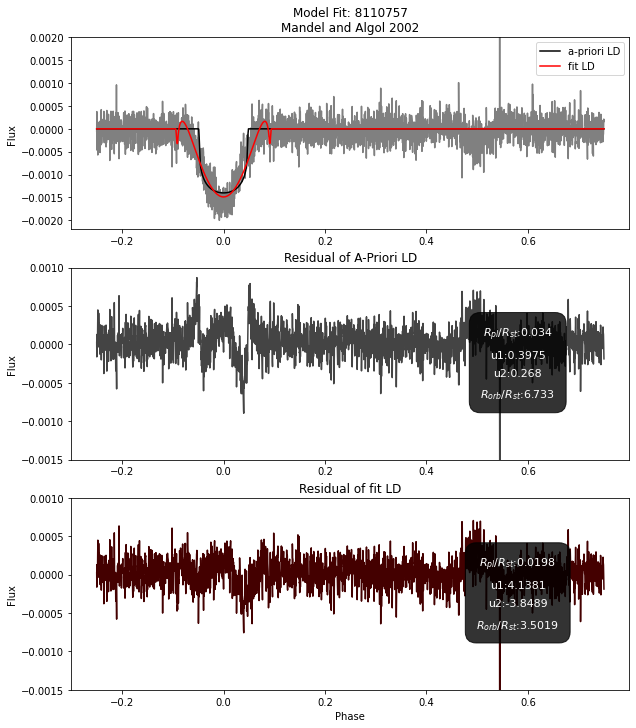

In [31]:
fig, ax = plt.subplots(3,1,figsize=(10,12))
kernel = np.ones(2)/2
exp = new_plar(np.array(df['phase']), *popt2)
exp2 = new_plar(np.array(df['phase']), *popt3)


props = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
txt = "$R_{pl}$/$R_{st}$:"+str(np.round(popt2[0],4))+"\nu1:"+str(np.round(popt2[1],4
    ))+"\nu2:"+str(np.round(popt2[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(popt2[3],4))

props2 = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
txt2 = "$R_{pl}$/$R_{st}$:"+str(np.round(popt3[0],4))+"\nu1:"+str(np.round(popt3[1],4
    ))+"\nu2:"+str(np.round(popt3[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(popt3[3],4))

ax[1].text(0.80, 0.5, txt, fontsize=11,transform=ax[1].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=2, bbox=props, color='white')
ax[2].text(0.80, 0.5, txt2, fontsize=11,transform=ax[2].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=2, bbox=props2, color='white')
ax[0].set_title('Model Fit: 8110757\nMandel and Algol 2002')
ax[0].plot(np.array(df['phase']),df['flux'], color='gray')
ax[0].plot(np.array(df['phase']), exp, color='black', label='a-priori LD')
ax[0].plot(np.array(df['phase']), exp2, color='red', label='fit LD')
ax[1].set_title('Residual of A-Priori LD')
ax[2].set_title('Residual of fit LD')
ax[2].set_xlabel('Phase')
ax[0].set_ylabel('Flux')
ax[2].set_ylabel('Flux')
ax[0].legend()
ax[1].set_ylabel('Flux')
ax[0].set_ylim(-0.0022,0.002)
ax[1].set_ylim(-0.0015,0.001)
ax[2].set_ylim(-0.0015,0.001)
ax[1].plot(np.array(df['phase']),np.convolve((exp - df['flux']),kernel, mode='same'), color='#444444')
ax[2].plot(np.array(df['phase']),np.convolve((exp2 - df['flux']),kernel, mode='same'), color='#440000')
#plt.savefig("this_is_a_fit.jpg")


In [148]:
#trying out a simulation
sim = dy.Simulator(1, 20000, 400, 0.1*np.pi, 0.3975, 0.2650)
meg = dy.Megastructure(6.98, True, 0.035, ecc=0, per_off=0, isrot=False)
sim.add_megs(meg)

# sim2 = dy.Simulator(1, 10000, 200, 0.1*np.pi, 2*0.3975, 0*0.2650)
# meg2 = dy.Megastructure(13.45, True, 1*0.035, ecc=0.377, per_off=np.pi/2, isrot=True)
# sim2.add_megs(meg2)

sim3 = dy.Simulator(1, 20000, 400, 0.1*np.pi, 0.3975, 0.2650)
meg3 = dy.Megastructure(6.98, True, 0.015, ecc=0, per_off=0, isrot=False)
sim3.add_megs(meg3)




In [149]:
netlc=[]
netph=[]
for i in range(50):
    np.random.seed(1234*i)
    road, ph, lc = sim.simulate_transit()
    netlc.append(lc)
    print('3d:',i)
    sim.initialize()

netlc3=[]
for i in range(50):
    np.random.seed(1234*i)
    road3, ph3, lc3 = sim3.simulate_transit()
    netlc3.append(lc3)
    print('3d2:',i)
    sim3.initialize()

'''netlc2=[]
for i in range(10):
    np.random.seed(3456*i)
    road2, ph2, lc2 = sim2.simulate_transit()
    netlc2.append(lc2)
    print('2d:',i)
    if(i==9): netph.append(ph2)
    sim2.initialize()'''

lc = np.mean(np.array(netlc), axis=0)
lc3 = np.mean(np.array(netlc3), axis=0)
#lc2 = np.mean(np.array(netlc2), axis=0)


3d: 0
3d: 1
3d: 2
3d: 3
3d: 4
3d: 5
3d: 6
3d: 7
3d: 8
3d: 9
3d: 10
3d: 11
3d: 12
3d: 13
3d: 14
3d: 15
3d: 16
3d: 17
3d: 18
3d: 19
3d: 20
3d: 21
3d: 22
3d: 23
3d: 24
3d: 25
3d: 26
3d: 27
3d: 28
3d: 29
3d: 30
3d: 31
3d: 32
3d: 33
3d: 34
3d: 35
3d: 36
3d: 37
3d: 38
3d: 39
3d: 40
3d: 41
3d: 42
3d: 43
3d: 44
3d: 45
3d: 46
3d: 47
3d: 48
3d: 49
3d2: 0
3d2: 1
3d2: 2
3d2: 3
3d2: 4
3d2: 5
3d2: 6
3d2: 7
3d2: 8
3d2: 9
3d2: 10
3d2: 11
3d2: 12
3d2: 13
3d2: 14
3d2: 15
3d2: 16
3d2: 17
3d2: 18
3d2: 19
3d2: 20
3d2: 21
3d2: 22
3d2: 23
3d2: 24
3d2: 25
3d2: 26
3d2: 27
3d2: 28
3d2: 29
3d2: 30
3d2: 31
3d2: 32
3d2: 33
3d2: 34
3d2: 35
3d2: 36
3d2: 37
3d2: 38
3d2: 39
3d2: 40
3d2: 41
3d2: 42
3d2: 43
3d2: 44
3d2: 45
3d2: 46
3d2: 47
3d2: 48
3d2: 49


In [4]:
from multiprocessing import Process, Pool

def test_multi_loops_3d(x):
    np.random.seed(1234*x)
    sim = dy.Simulator(1, 2000, 200, 0.1*np.pi, 2*0.3975, 0.2650)
    meg = dy.Megastructure(13.45, True, 0.035, ecc=0.377, per_off=np.pi/2)
    sim.add_megs(meg)
    sim.simulate_transit()
    if(x==0): print("Count:", meg.set)
    return(sim.frames,sim.lc)

def test_multi_loops_2d(x):
    np.random.seed(3456*x)
    sim2 = dy.Simulator(1, 2000, 200, 0.1*np.pi, 2*0.3975, 0.2650)
    meg2 = dy.Megastructure(13.45, True, 0.035, ecc=0.377, per_off=np.pi/2, isrot=True)
    sim2.add_megs(meg2)
    if(x==0): print("Count:", meg.set)
    sim.simulate_transit()
    return(sim.frames,sim.lc)



if __name__ == '__main__':
    # start 4 worker processes
    with Pool(processes=4) as pool:
        frm,lc2dsum = np.asarray(pool.map(test_multi_loops_2d, range(8)))
        lc2d = np.mean(lc2dsum, axis = 0)
        #print("--- %s min ---" % ((time.time() - start_time)/60))

        frm,lc3dsum = np.asarray(pool.map(test_multi_loops_3d, range(8)))
        #print("--- %s min ---" % ((time.time() - start_time)/60))

        lc3d = np.mean(lc3dsum, axis = 0)

        mn = (np.asarray(lc3d-lc2d)**2).sum()/len(lc3d)
        print(np.sqrt(mn))


Text(0, 0.5, 'Flux')

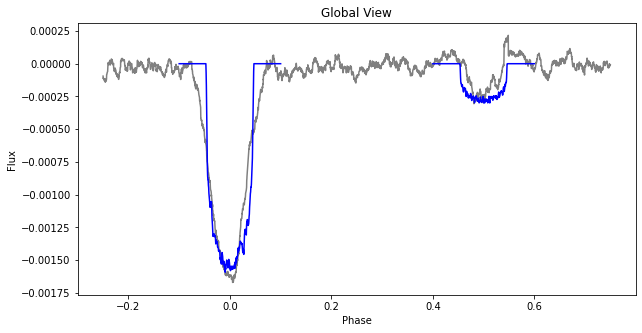

In [152]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(10,5))
#print(lc.shape, ph.shape)
kernel = np.ones(30)/30
plt.plot(np.array(df['phase']),np.convolve(np.array(df['flux']), kernel,mode='same'),color='gray')
plt.plot(np.array(ph)/np.pi,np.array(lc)-1, color='blue', label='3d')
#plt.plot(np.array(ph)/np.pi,np.array(lc2)-1, color='blue', label='2d')
plt.plot(np.array(ph)/np.pi+0.5,np.array(lc3)-1, color='blue', label='3d')
plt.title('Global View')
plt.xlabel('Phase')
plt.ylabel('Flux')
#plt.xlim(-0.1,+0.1)
#plt.ylim(-0.2,.2)
#plt.savefig('not_a_fit.png')